In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.spatial import distance

# Uvod

V predhodnih študijah se je izkazalo, da ima vsak uporabnik svoj slog branja novic, zato smo se tudi odločili za personalizacijo splošnega napovednega modela. Glede na to, da želimo personalizacijo doseči v čim krajšem času smo uporabili aktivno strojno učenje. Zaradi raznolikosti uporabnikov pa ne vemo, kateri algoritem aktivnega strojnega učenja bo na posamezniku deloval najboljše. V bolj dinamičnih okoljih so v članku [Adaptive Active Learning as a Multi-armed Bandit Problem](https://www.researchgate.net/publication/264902057_Adaptive_Active_Learning_as_a_Multi-armed_Bandit_Problem) predlagali uporabo večih metod aktivnega učenja, med katerimi menjavamo s pomočjo algoritma UCB. V našem primeru smo izbrali naslednje tehnike aktivnega strojnega učenja:

1. **Razmik prepričanosti (angl. Margin of Confidence)** - ta metoda vzame dva najbolj verjetna podatka na izhodu in preveri, ali je razlika med njunima verjetnostima izhoda dovolj velika. V primeru, da je potem vprašalnika uporabniku ne zastavimo. Na tem mestu velja omeniti, da na parametre prikaza novic gledamo kot na vhod. To pomeni, da iteriramo čez vse možne prikaze novic in pogledamo za katerega izmed njih je model v določenem trenutku najbolj prepričan, da se klasificira kot "Da". Težava na katero naletimo je, da se verjetnosti v tem primeru ne seštejejo v ena. Problem lahko rešimo, da verjetnosti normaliziramo s pomočjo funkcije softmax.
2. **Naključna odločitev** - druga metoda, ki smo jo uporabili za odločitev, ali je uporabniku potrebno zastaviti vprašalnik, je popolnoma naključna. To pomeni, da se v nekem trenutku naključno odločimo, ali prikažemo vprašalnik. Prednost metode, ki je čisto naključna je ta, da bo raziskovala najbolj raznolik prostor podatkov.
3. **Naključno z upoštevanjem porazdelitve fizične aktivnosti** - glede na to, da se je pri analizi podatkov kazal velik vpliv fizične aktivnosti na končno oceno uporabnika smo se odločili na podlagi njene porazdelitve naključno zastaviti vprašalnik. Iz prve študije smo ugotovili, da uporabniki največ berejo novice, ko so pri miru in nam primanjkujejo podatki, ko se vozijo ali pa se sprehajajo. Da bi dali prednost zbiranju podatkov, ko uporabniki hodijo in se vozijo moramo takrat zastaviti največji delež vprašalnikov. To lahko dosežemo z upoštevanjem trenutne porazdelitve fizčne aktivnosti. Verjetnost, da se bo vprašalnik pojavil, ko je uporabnik pri miru mora biti najmanjša. Višja morata biti verjetnost pojavitve vprašalnika med hojo, najvišja pa med vožnjo v avtomobilu, saj imamo takih podatkov najmanj.
4. **Vzorečnje najmanj verjetnih izhodov (angl. Least Confidence sampling)** - pri tej metodi iščemo podatke, ko je verjetnost najboljšega prikaza novic pod odločitveno mejo modela, ki znaša 0.5. To pomeni, da bomo vprašalnik zastavali takrat, ko je verjetnost najboljšega prikaza novic, ki ga model označi kot "Da" pod vrednostjo 0.5.

# Algoritem UCB

Na področju spodbujevalnega strojnega učenja mora agent na podlagi interakcije z okolico sklepati, katera akcija je najboljša. Naloga agenta je torej iskanje strategije oz. zaporedja akcij brez vnaprej označenih podatkov. Iskanje učinkovite strategije menjave metod aktivnega strojnega učenja si lahko predstavljamo kot [Multi-armed bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit). V tem primeru je agent hazarder, ki želi maksimizirat svoj izkupiček z igranjem na avtomatih. Na vsakem koraku se mora ta namreč odločiti, ali igrati na avtomatu, ki je do sedaj prinesel največji dobiček ali pa na drugem, ki bi morda lahko prinesel še višjo nagrado. V našem primeru se avtomati za srečo preslikajo v tehnike aktivnega strojnega učenja. Potrebno je uravnotežiti število izbir metode aktivnega strojnega učenja, ki se je do sedaj izkazala kot najboljša in poskuse preostalih metod, ki bi se morda lahko izkazale kot še boljše.

Alogirtem UCB (Upper Confidence Bound) se je izkazal kot eden bolj učinkovitih pri reševanju omenjenega problema. Ta temelji na sledeči enačbi:

<img src="https://latex.codecogs.com/svg.latex?\Large&space;A_t=argmax_a(Q_t(a) + c \sqrt\frac{ln(t)}{N_t(a)})"/>


* Prvi del enačbe Qt(a) predstavlja povprečno nagrado, ki jo je agent do sedaj pridobil z uporabo tehnike a in omogoča izkoriščanje uporabe do sedaj najboljše tehnike. 

* Drugi del enačbe pa predstavlja zgornjo mejo, ki jo agent dopušča za raziskovanje nove tehnike aktivnega strojnega učenja in je odvisna od števila do sedaj znanih poskusov na tehniki a. Večkrat kot smo izbrali določeno tehniko, manj jo želimo ponovno poskusiti, zato se tudi v imenovalcu nahaja člen Nt(a), ki predstavlja število do sedaj znanih poskusov na izbrani tehniki. Pri tem pa moramo upoštevati trenutno učinkovitost tehnike a, ki se nahaja v prvem delu enačbe (Qt(a)).

Grafična predstavitev zgornje enačbe:

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200126022459/Screenshot-2020-01-26-at-2.24.37-AM.png"/>

# Analiza zbranih podatkov druge študije

V nadaljevanju bodo predstavljeni zbrani podatki druge študije, ki je trajala štiri tedne in v kateri je sodelovalo sedem ljudi. V prvem delu študije, ki je trajal dva tedna smo skušali splošni napovedni model personalizirati s pomočjo algoritma UCB. V drugem delu študije pa smo želeli z vsakodnevno menjavo personaliziranega in splošnega napovednega modela primerjati njuno učinkovitost.


In [157]:
## nalaganje podatkov

column_names_r = ["uID", "margin_of_conf", "random", "random_by_ua", "least_confidence", "total_reward", "all_pulls", "regret"]
rewards_df = pd.read_csv("Dataset/rewards.csv", header=None, names=column_names_r, sep=";")

column_names_p = ["uID", "margin_of_conf", "random", "random_by_ua", "least_confidence", "all_pulls"]
pulls_df = pd.read_csv("Dataset/pulls.csv", header=None, names=column_names_p, sep=";")

column_names_b = ["uID", "trial", "bandit_index", "bandit_decision", "reward", "regret", "total_reward"]
bandit_df = pd.read_csv("Dataset/bandit.csv", header=None, names=column_names_b, sep=";")

column_names_pr = ["uID", "user_activity", "env_b", "theme", "layout", "fontSize", "predictionProb", "feedback"]
pred_df = pd.read_csv("Dataset/predictions.csv", header=None, names=column_names_pr, sep=";")

column_names_ph2 = ["uID", "algo", "user_activity", "env_b", "theme", "layout", "fontSize", "feedback"]
ph2_df = pd.read_csv("Dataset/phase2.csv", header=None, names=column_names_ph2, sep=";")

# Analiza algoritma UCB in posameznih tehnik aktivnega strojnega učenja

V spodnji tabeli je predstavljena učinkovitost algoritma UCB in posameznih tehnik aktivnega strojnega učenja na posamezniku. 

V prvem stolpcu tabele se nahajajo identifikatorji uporabnikov. Drugi stolpec predstavlja vektor nagrad, ki jih je pridobila posamezna tehnika aktivnega strojnega učenja, ki si sledijo v naslednjem zaporedju:

1. Razmik prepričanosti (angl. Margin of Confidence) 
2. Naključna odločitev postavitve vprašalnika
3. Naključno z upoštevanjem porazdelitve fizične aktivnosti
4. Vzorečnje najmanj verjetnih izhodov (angl. Least Confidence sampling)


V tretjem stolopcu vidmo kolikokrat je bila tehnika aktivnega strojnega učenja izbrana. V četrtem se nahaja skupno število poskusov algoritma UCB. V petem razberemo skupno vsoto, ki so jo dobile tehnike aktivnega strojnega učenja. V predzadnjem stolopcu se nahaja število vseh poskusov algoritma UCB, ko je naletel na kazen. V zadnjem pa lahko razberemo delež napačnih izbir algorima UCB.


## Analiza tabele

* Pri uporabnikih z identifikatorji 0, 2 in 3 se kaže visoka učinkovitost prvih dveh metod aktivnega učenja. Prav tako je odstotek napačnih izbir tehnik aktivnega učenja majhen (12.67%, 16%, 8.33%). Na teh uporabnikih je algoritem UCB zaradi visokih vsot skupne nagrade največkrat tudi uporabil prvo metodo. Pri uporabniku z indeksom 3 pa se kaže nekoliko bolj enakomerna menjava prve in druge metode aktivnega učenja. 

* Čeprav je uporabnik z identifikatorjem 1 aplikacijo malo uporabljal (prispeval je le 14 vnosov), algoritem UCB vseeno ni naredil preveliko število napačnih izbir. Delež zgrešenih poskusov je namreč le 21.43%. Vseeno se tudi pri tem uporabniku izkažeta prvi dve metodi aktivnega učenja kot najboljši. 

* Uporabnik z identifikatorjem 4 je prispeval v prvem delu druge študije najmanj vnosov. Pri njem se tudi kaže največji delež napačnih izbir metod aktivnega strojnega učenja, ki znaša 40%. Vzrok za tako velik odstotek napačnih odločitev je ta, da algoritem UCB ni uspel konvergirati k najboljši metodi, saj uporabnik aplikacije ni veliko uporabljal. Vseeno sta se prvi dve metodi aktivnega učenja pri tem uporabniku izkazali nekoliko boljši kot drugi dve.

* Nobena izmed metod aktivnega učenja ne odstopa pri uporabikih z identifikatorji 5 in 6. Posledično tudi algoritem UCB ni uspel pri njima določiti, katera metoda aktivnega učenja je najboljša. Čeprav je uporabnik z identifikatorjem 5 prispeval velik delež vnosov algoritem UCB na tem uporabniku ni deloval dobro. Skupna nagrada je celo negativna prav tako pa je število posameznih poskusov enakomerno porazdeljeno. Omenjena dva uporabnika bomo v nadaljevanju analize podrobneje analizirali.

| Uporabnik | Skupna nagrada posameznih metod | Število posameznih poskusov | Skupno števlo poskusov | Skupna nagrada | Število zgrešenih poskusov | Delež zgrešenih poskusov |
|-----------|---------------------------------|-----------------------------|------------------------|----------------|----------------------------|--------------------------|
| 0         | [31.72, 5.47, -3.40, -1.98]     | [50, 16, 2, 3]              | 71                     | 31.82          | 9                          | 12.67%                   |
| 1         | [3.79, 4.08, -1.90, -1.93]      | [5, 6, 1, 2]                | 14                     | 4.04           | 3                          | 21.43%                   |
| 2         | [15.34, 2.07, -1.95, -1.75]     | [15, 6, 2, 2]               | 25                     | 13.71          | 4                          | 16.00%                   |
| 3         | [26.04, 12.60, -1.41, -1.85]    | [34, 21, 3, 2]              | 60                     | 35.38          | 5                          | 8.33%                    |
| 4         | [1.54, 2.73, -0.01, -0.01]      | [2,2,4,2]                   | 10                     | 4.25           | 4                          | 40%                      |
| 5         | [-0.02, 2.50, -0.50, -2.50]     | [17, 23, 15, 11]            | 66                     | -0.27          | 8                          | 12.12%                   |
| 6         | [1.38, 0.39, -1.71, -2.25]      | [6,5,3,2]                   | 16                     | -2.20          | 5                          | 31.25%                   |

# Graf kumulativne nagrade skozi čas

Radi bi preverili spreminjanje vsote nagrad skozi čas. Na ordinatni osi bo torej vsota prejete nagrade do n-tega poskusa. Zaradi preglednosti bomo narisali dva različna grafa, saj so udeleženci raziskave prispevali različno število vnosov. Posledično bi graf funkcije bil manj pregleden za tiste uporabnike, ki so aplikacijo manj uporabljali.

Iz spodnjih grafov, vidimo, da je vsota nagrad skozi čas naraščala pri večini uporabnikov.

Uporabnika z identifikatorji 5 (zelena črta na prvem grafu) in 6 (rdeča črta na drugem grafu) tako kot pri zgornji tabeli odstopata od ostalih uporabnikov.

In [13]:
def plot_rewards(userIDs, ax):
    for userID in userIDs:
        rewards = bandit_df.loc[( bandit_df["uID"] == userID )]["total_reward"].tolist()
        trials = bandit_df.loc[( bandit_df["uID"] == userID )]["trial"].tolist()
        ax.legend(userIDs)
        ax.plot(trials, rewards, label=userID)

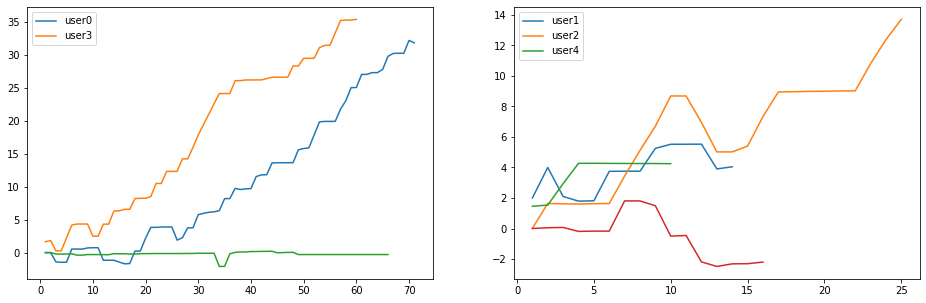

In [14]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,2,1)
plot_rewards(["user0", "user3", "user5"], ax1)
ax2 = fig.add_subplot(1,2,2)
plot_rewards(["user1", "user2", "user4", "user6"], ax2)

# Analiza parametrov konteksta

V okviru druge študije smo uporabili fizično aktivnost in svetlost okolice za napovedovanje parametrov prikaza novic. Omenjena dva parametra konteksta sta se namreč v prvi raziskavi izkazala kot najbolj pomembna izmed preostalih. 

Glede na to, da se druga raziskava deli na dva dela si bomo pogledali porazedlitev fizične aktivnosti in svetlosti okolice za posameznika v prvem in drugem delu študije. S pomočjo metrike Jensen–Shannon, ki temelji na Kullback-Leiber divergenci, si bomo pogledali, kolikšna je razlika med porazdelitvijo podatkov.


# Analiza fizične aktivnosti uporabnika 

In [138]:
def anlyze_user_activity(userIDs):
    for userID in userIDs:
        c0 = len(pred_df.loc[ ( pred_df["user_activity"] == "STILL" ) & ( pred_df["uID"] == userID ) ])
        c1 = len(pred_df.loc[ ( pred_df["user_activity"] == "ON_FOOT" ) & ( pred_df["uID"] == userID ) ])
        c2 = len(pred_df.loc[ ( pred_df["user_activity"] == "IN_VEHICLE" ) & ( pred_df["uID"] == userID ) ])
        
        c00 = len(ph2_df.loc[ ( ph2_df["user_activity"] == "STILL" ) & ( ph2_df["uID"] == userID ) ])
        c01 = len(ph2_df.loc[ ( ph2_df["user_activity"] == "ON_FOOT" ) & ( ph2_df["uID"] == userID ) ])
        c02 = len(ph2_df.loc[ ( ph2_df["user_activity"] == "IN_VEHICLE" ) & ( ph2_df["uID"] == userID ) ])
        
        print(userID)
        print("Porazdelitev podatkov po fizični aktivnosti prvi del druge študije", [c0, c1, c2])
        print("Porazdelitev podatkov po fizični aktivnosti drugi del druge študije", [c00, c01, c02])
        jsd = distance.jensenshannon([c0, c1, c2], [c00, c01, c02], 2.0)
        print("Jensen–Shannon = ",jsd)
      
        print("==========================")

In [139]:
anlyze_user_activity(["user0", "user1", "user2", "user3", "user4", "user5", "user6"])

user0
Porazdelitev podatkov po fizični aktivnosti prvi del druge študije [69, 11, 0]
Porazdelitev podatkov po fizični aktivnosti drugi del druge študije [74, 3, 0]
Jensen–Shannon =  0.151508271543536
user1
Porazdelitev podatkov po fizični aktivnosti prvi del druge študije [16, 0, 0]
Porazdelitev podatkov po fizični aktivnosti drugi del druge študije [19, 3, 0]
Jensen–Shannon =  0.2679249460757801
user2
Porazdelitev podatkov po fizični aktivnosti prvi del druge študije [25, 0, 0]
Porazdelitev podatkov po fizični aktivnosti drugi del druge študije [74, 6, 0]
Jensen–Shannon =  0.19635219282765295
user3
Porazdelitev podatkov po fizični aktivnosti prvi del druge študije [60, 10, 0]
Porazdelitev podatkov po fizični aktivnosti drugi del druge študije [24, 16, 1]
Jensen–Shannon =  0.2716812363544374
user4
Porazdelitev podatkov po fizični aktivnosti prvi del druge študije [10, 0, 0]
Porazdelitev podatkov po fizični aktivnosti drugi del druge študije [11, 1, 2]
Jensen–Shannon =  0.34123263793868

Iz zgornjih izpisov ugotovimo, da so uporabniki ponovno aplikacijo uporabljali, ko so bili pri miru in zelo malo med vožnjo in hojo. Prav tako pa so vrednosti metrike Jensen–Shannon blizu nič, kar pomeni, da porazdelitve podatkov fizične aktivnosti so podobne. Največje odstopanje, se kaže pri uporabniku z identifikatorjem 4, pri katerem metrika Jensen-Shanon znaša 0.34

# Analiza svetlosti okolice

Pri analizi svetlosti okolice smo tako kot pri prvi študiji svetlost okolice razdelili v štiri različne kategorije

* V prvi skupini so vrednosti svetlosti okolice na intervalu [0-20]
* V drugi skupini so vrednost svetlosti okolice na intervalu [21-50]
* V tretji skupini se nahajajo vrednosti na intevralu [51-100]
* V Četrti skupini pa imamo vrednosti, ki so večje od 101 lux

In [51]:
def izrisi_svetlost_okolice(vals, ax, s):
    print("Stevilo vnosov glede na svetlost okolice ",s,vals)
    labels = ['0-20', '21-50','51-100', '101>=']
    y_pos = np.arange(len(labels))
    ax.bar(y_pos, vals, align='center')
    ax.set_xticklabels(labels, fontdict=None, minor=True)
    ax.set_ylabel('Stevilo vnosov')
    

In [140]:
def analyze_env_b(userID):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1,2,1)
    
    c0 = len(pred_df.loc[ (pred_df["env_b"] >=0 ) & (pred_df["env_b"] <= 20) & ( pred_df["uID"] == userID ) ])
    c1 = len(pred_df.loc[ (pred_df["env_b"] >=21 ) & (pred_df["env_b"] <= 50) & ( pred_df["uID"] == userID ) ])
    c2 = len(pred_df.loc[ (pred_df["env_b"] >=51 ) & (pred_df["env_b"] <= 100) & ( pred_df["uID"] == userID ) ])
    c3 = len(pred_df.loc[ (pred_df["env_b"] >=101 ) & ( pred_df["uID"] == userID ) ])
    izrisi_svetlost_okolice([c0, c1, c2, c3], ax1, "v prvem delu študije")
    
    ax2 = fig.add_subplot(1,2,2)
    c00 = len(ph2_df.loc[ (ph2_df["env_b"] >=0 ) & (ph2_df["env_b"] <= 20) & ( ph2_df["uID"] == userID ) ])
    c01 = len(ph2_df.loc[ (ph2_df["env_b"] >=21 ) & (ph2_df["env_b"] <= 50) & ( ph2_df["uID"] == userID ) ])
    c02 = len(ph2_df.loc[ (ph2_df["env_b"] >=51 ) & (ph2_df["env_b"] <= 100) & ( ph2_df["uID"] == userID ) ])
    c03 = len(ph2_df.loc[ (ph2_df["env_b"] >=101 ) & ( ph2_df["uID"] == userID ) ])
    izrisi_svetlost_okolice([c00, c01, c02, c03], ax2, "v drugem delu študije")
    
    l1 = pred_df.loc[pred_df["uID"] == userID ]["env_b"].tolist()
    l2 = ph2_df.loc[ph2_df["uID"] == userID ]["env_b"].tolist()
    
    
    ks = ks_2samp(l1, l2)
    jsd = distance.jensenshannon([c0, c1, c2, c3], [c00, c01, c02, c03], 2.0)
    print("Jensen–Shannon = ", jsd)
    
    print("==========================")

### Prvi uporabnik

Pri prvem uporabniku lahko opazimo, da je porazdelitev podatkov prve in druge študije zelo podobna. Vrednost metrike Jensen–Shannon je blizu 0. 

Stevilo vnosov glede na svetlost okolice  v prvem delu študije [40, 4, 11, 25]
Stevilo vnosov glede na svetlost okolice  v drugem delu študije [32, 7, 12, 26]
Jensen–Shannon =  0.08900793465248628


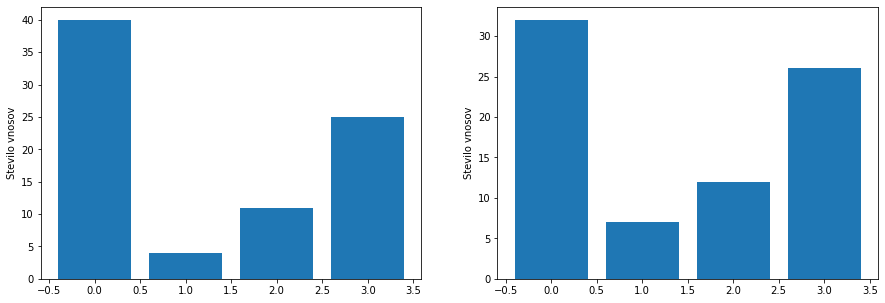

In [143]:
analyze_env_b("user0") 

### Drugi uporabnik

Če primerjamo porazdelitev svetlosti okolice za drugega uporabnika, opazimo, da se v prvem in drugem delu študije ti razlikujejo. Vrednost metrike Jensen–Shannon znaša 0.4. Razlog za to je, da v tretjem intervalu svetlosti okolice v prvem delu študije pri tem uporabniku bilo zbranih 0 vnosov.

Stevilo vnosov glede na svetlost okolice  v prvem delu študije [4, 8, 0, 4]
Stevilo vnosov glede na svetlost okolice  v drugem delu študije [6, 7, 6, 3]
Jensen–Shannon =  0.4045366569430508
Distributions are equal


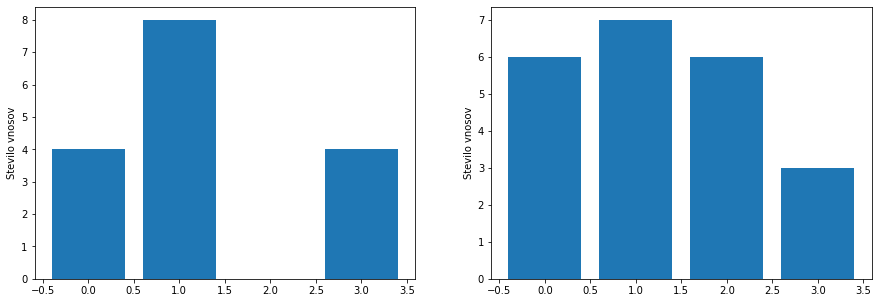

In [66]:
analyze_env_b("user1") 

### Tretji uporabnik

Pri tretjem uporabniku se opazijo razlike v porazdelitvi svetlosti okolice. Razlog za to je, da je ta uporabnik v drugem delu študije prispeval veliko več vnosov kot pri prvem. Pri njem je opazno tudi to, da je aplikacijo uporabljal v bolj temnih prostorih.

Stevilo vnosov glede na svetlost okolice  v prvem delu študije [15, 3, 1, 6]
Stevilo vnosov glede na svetlost okolice  v drugem delu študije [78, 2, 0, 0]
Jensen–Shannon =  0.4437709107615337


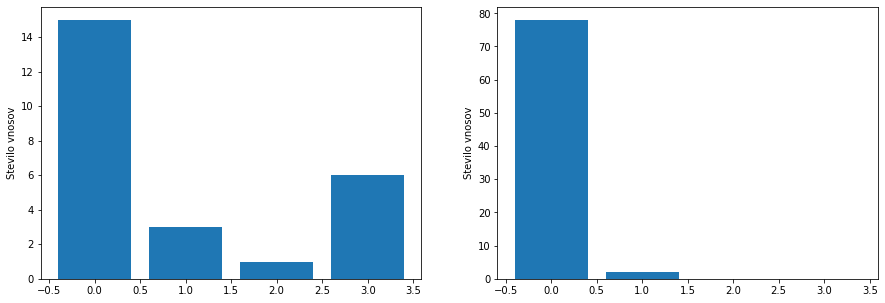

In [144]:
analyze_env_b("user2") 

### Četrti uporabnik

Pri četrtem uporabniku opazimo, da je porazdelitev v svetlosti okolice zelo podobna. Vrednost metrike Jensen–Shannon je zelo majhna.

Stevilo vnosov glede na svetlost okolice  v prvem delu študije [22, 12, 0, 36]
Stevilo vnosov glede na svetlost okolice  v drugem delu študije [16, 7, 0, 18]
Jensen–Shannon =  0.0714506052588547


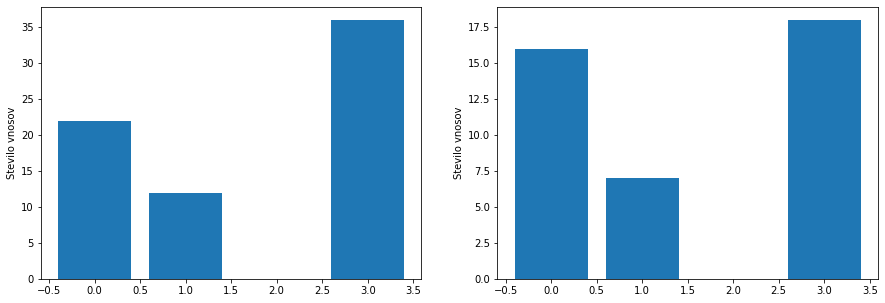

In [146]:
analyze_env_b("user3") 

### Peti uporabnik

Pri petem uporabniku vidimo, da je aplikacijo večinoma uporabljal v temnem prostoru. Skozi celotno študijo je ta uporabnik prispeval najmanj vnosov. 

Stevilo vnosov glede na svetlost okolice  v prvem delu študije [10, 0, 0, 0]
Stevilo vnosov glede na svetlost okolice  v drugem delu študije [11, 0, 0, 3]
Jensen–Shannon =  0.3412326379386844


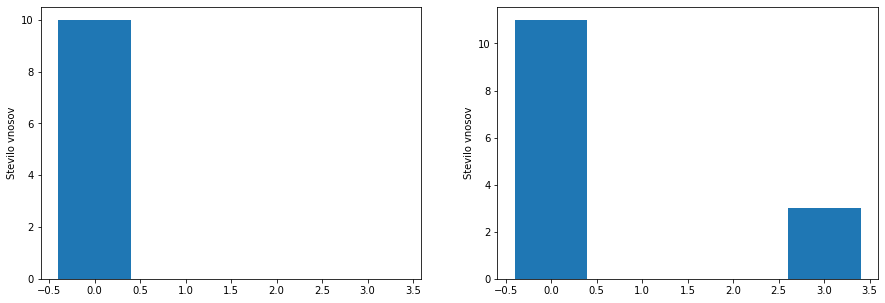

In [148]:
analyze_env_b("user4") 

### Šesti uporabnik

Šesti uporabnik je v prvem in drugem delu študije prispeval veliko vnosov tako v prvem kot tudi v drugem delu študije. Porazdelitev podatkov za svetlost okoloce sta si podobni, saj je vrednost metrike Jensen-Shannon blizu 0.


Stevilo vnosov glede na svetlost okolice  v prvem delu študije [18, 20, 12, 28]
Stevilo vnosov glede na svetlost okolice  v drugem delu študije [17, 19, 24, 19]
Jensen–Shannon =  0.1641102997206995


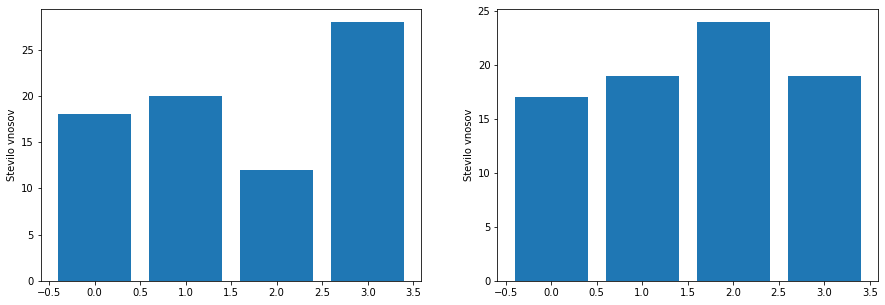

In [150]:
analyze_env_b("user5") 

### Sedmi uporabnik

Pri sedmem uporabniku opazimo, da je aplikacijo uporabljal v prvem in drugem delu študije v temnih kot tudi svetlejših prostorih. Večina vnosov za svetlost okolice je bila na intervalu [0-51] lux. Nizka vrednost metrike Jensen-Shanon potrjuje, da sta si porazdelitvi podatkov podobni.


Stevilo vnosov glede na svetlost okolice  v prvem delu študije [14, 7, 0, 4]
Stevilo vnosov glede na svetlost okolice  v drugem delu študije [10, 2, 0, 1]
Jensen–Shannon =  0.18996105778999636


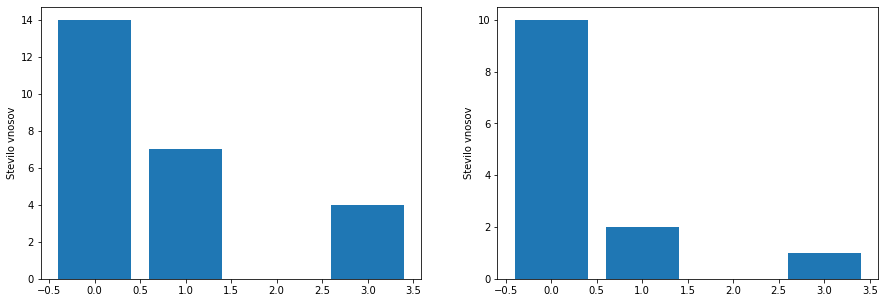

In [152]:
analyze_env_b("user6")

# Analiza odgovorov na vprašalnik

Omenili smo, da bomo poiskali razlog, zakaj algoritem UCB pri zadnjih dveh uporabnikih ni deloval dovolj dobro. 

V nadaljevanju si bomo zato najprej pogledali, ali se morda odgovori pri šestem in sedmem uporabniku, na zastavljen vprašalnik, med seboj močno razlikujejo od ostalih uporabnikov.

In [153]:
def draw_pie(labels, sizes, ax, userID):
    ax.set_title(userID)
    ax.pie(sizes, labels=labels,
            autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal')


In [154]:
def analyze_user_y_n():
    fig = None
    for i in range(0,7):
        
        if i%3 == 0:
            fig = plt.figure(figsize=(15, 5))

        ax = fig.add_subplot(1,3,i%3 + 1)
        userYes = len(pred_df.loc[ (pred_df["uID"] == "user"+str(i)) & (pred_df["feedback"]  == 'Y')])
        userNo = len(pred_df.loc[ (pred_df["uID"] == "user"+str(i)) & (pred_df["feedback"]  == 'N')])
        print("User", i, "Yes = ",userYes, "No = ", userNo)
        draw_pie(["yes", "no"], [userYes, userNo], ax, "user"+str(i))

User 0 Yes =  46 No =  25
User 1 Yes =  7 No =  7
User 2 Yes =  8 No =  17
User 3 Yes =  34 No =  26
User 4 Yes =  7 No =  3
User 5 Yes =  64 No =  2
User 6 Yes =  13 No =  3


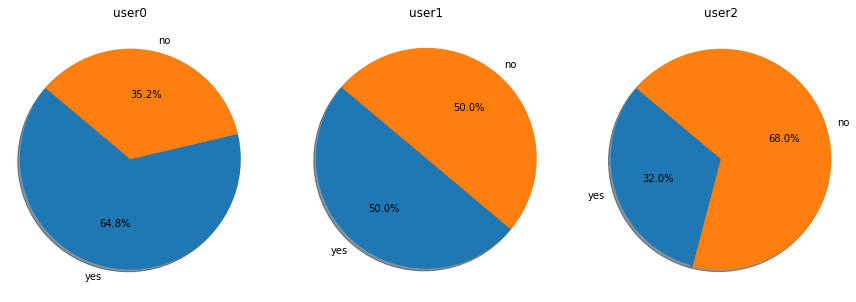

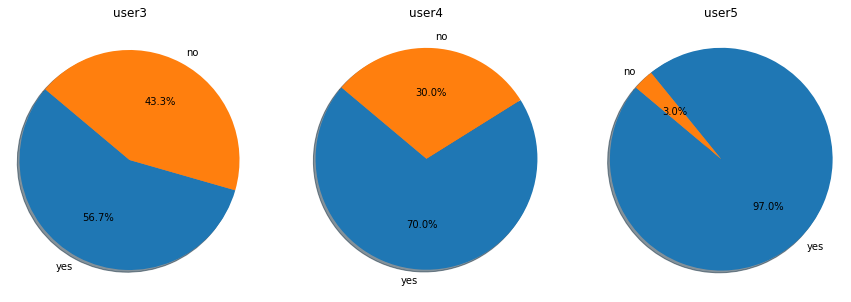

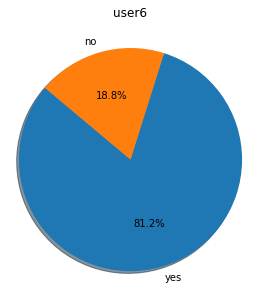

In [155]:
analyze_user_y_n()

Zgornji tortni diagrami so prikaz uporabnikovih odgovorov v prvem delu študije. Udeleženci raziskave so imeli na voljo le dva odgovora "Da" in "Ne". 

Pri petem in šestem tortnem diagramu, ki prikazuje odgovore najbolj kritičnih uporabnikov v prvem delu študije (algoritem UCB je imel nagrado negativno) opazimo razlike v odgovorih v primerjavi z ostalimi.

Deleža njunih odgovorov z "Da" znašata 81.2% in kar 97%. To pomeni, da je obema uporabnikoma, katerikoli prikaz novic v vsakem trenutki, bil všeč. Posledično je to lahko, razlog za slabšo učinkovitost algoritma UCB, saj sta oba uporabnika z vsemi uporabniškimi vmesniki zadovoljna. Peti uporabnik, je tudi prispeval veliko manj vnosov (16 vnosov) kot šesti (66 vnosov). Razlog za slabšo učinkovitost algoritma UCB pri petem uporabniku je lahko tudi premajhna količina novih podatkov.


# Primerjava učinkovitosti splošnega in personaliziranega napovednega modela

Omenili smo, da bomo v drugem delu druge študije primerjali učinkovitost splošnega in personaliziranega napovednega modela. Spodnja tabela število napovedi omenjenih modelov in delež napovedi s katerimi je bil uporabnik zadovoljen. 

Iz spodnje tabele opazimo, da personalizacija napovednih modelov, poveča uporabnikovo zadovoljstvo pri vseh uporabnikih razen pri uporabniku z identifikatorjem 4. Razlog za to je, da je ta v prvem delu študije prispeval najmanj podatkov (zbranih je bilo samo 10 vnosov). Prav tako pa je število napovedi splošnega modela pri tem uporabniku veliko manjša od števila napovedi personaliziranega. Razlog za to je, da je pojavitev vprašalnika odvisna od števila kolikrat uporabnik vstopi na zaslon za prikaz novic.

Prav tako je zadnji uporabnik prispeval v drugem delu študije malo vnosov (skupno 13), a se vseeno kaže višja učinkovitost delovanja personaliziranega napovednega modela

| Uporabnik | Št. napovedi splošnega modela | Št. napovedi personaliziranega modela | Točnost splošnega modela | Točnost personaliziranega modela |
|-----------|-------------------------------|---------------------------------------|--------------------------|----------------------------------|
| 0         | 32                            | 45                                    | 47%                      | 71%                              |
| 1         | 9                             | 13                                    | 44%                      | 69%                              |
| 2         | 49                            | 31                                    | 51%                      | 61%                              |
| 3         | 15                            | 26                                    | 47%                      | 73%                              |
| 4         | 3                             | 11                                    | 66%                      | 36%                              |
| 5         | 31                            | 48                                    | 68%                      | 98%                              |
| 6         | 6                             | 7                                     | 33%                      | 71%                              |